# Float example

This notebook shows a simple example for tracking two particles with a custom kernel using HYCOM forcing and visualizing the output

In [26]:
# Define your own Kernel - could use this to add diel migration, other behavior
def MyKernel(particle, fieldset, time):
    
    # set particle salinity at new depth for output
    particle.salt =  fieldset.salt[time, particle.depth, particle.lat, particle.lon]

    # can code vertical diffusivity here with random walk
    # ocean parcels has some random walk functions as well
    # have particle.dt for time step, particle.depth for depth
    
    # for now, lock to depth (surface)
    particle.depth = 0
    

Run OceanParcels with the Custom Kernel.  Thus horizontal advection (and updated position) will be handled by OceanParcels and interpolation of hydrography by the MyKernel

In [29]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
from datetime import timedelta, datetime
import numpy as np


# Load the HYCOM Analysis data in the Gulf of Maine
# The paths/datafiles should be read in from a control file
filenames = {'U': "./ex1_hycom.nc",
             'V': "./ex1_hycom*.nc",
             'salt': "./ex1_hycom*.nc"}
variables = {'U': 'water_u',
             'V': 'water_v',
             'salt': 'salinity'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'depth' : 'depth' , 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)#,allow_time_extrapolation = True)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# print the domain boundaries to the screen
print("domain boundaries")
print(fieldset.U.lon[0],fieldset.U.lon[-1],fieldset.U.lat[0],fieldset.U.lat[-1])

    
# Define a new Particle type including extra Variables
class MyParticle(JITParticle):
    salt = Variable('salt', dtype=np.float32, initial=np.nan)  # store salinity

# Initiate two particles with staggered starts and two strating points.  
# These variables here (lon, lat, time) should be read in from an initial particle position file
pset = ParticleSet.from_list(fieldset=fieldset,
                            pclass=MyParticle,
                            lon=[-69.5,-69.],
                            lat=[42.5,42.5],
                            depth=[0,0],
                            time=[datetime(2016, 6, 1),
                            datetime(2016,6,2,0,0,0)])


# combine Argo vertical movement kernel with built-in Advection kernel
kernels = MyKernel + pset.Kernel(AdvectionRK4)
#kernels = IsoPycnalVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
# outputdt might be read in from a control file
output_file = pset.ParticleFile(name="ex1_tracks.nc", outputdt=timedelta(minutes=30))

# Now execute the kernels for 2 days with a 5 minute timestep
# dt and runtime might be read in from a control file
# for backtracking use a negative value for dt
pset.execute(kernels, runtime=timedelta(days=3), dt=timedelta(minutes=5), output_file=output_file)

# export the trajectory data to a netcdf file
output_file.export()  

print("done tracking")


domain boundaries
-71.03998 -68.0 41.0 44.0


/Users/gcowles/opt/anaconda3/envs/py3_parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
INFO: Compiled ArrayMyParticleMyKernelAdvectionRK4 ==> /var/folders/bn/dmp7fjns0klgnb_h42x7h6nr0000gn/T/parcels-501/libd301faa6e95638bf1ac751347f65c339_0.so


done tracking


/Users/gcowles/opt/anaconda3/envs/py3_parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Now we can plot the trajectory of the Isopycnal float with some simple calls to netCDF4 and matplotlib

(41.0, 43.5)

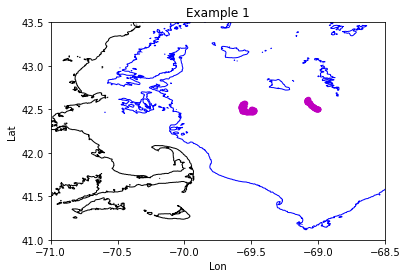

In [28]:
%matplotlib inline
#uncomment below for interactive plots (need ipympl)
####%matplotlib widget
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# plot gebco bathy contours 
ds = Dataset('gebco_2021_n50.0_s30.0_w-80.0_e-50.0.nc')
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
elev = ds.variables['elevation'][:]

# read data
nc = Dataset("ex1_tracks.nc")
xp = nc.variables["lon"][:].squeeze()
yp = nc.variables["lat"][:].squeeze()
nc.close()



fig, ax = plt.subplots()
plt.contour(lons,lats,-elev,[0,100,1000],colors=['black','blue','red'],linewidths=[1,1,1])


ax.set_title('Example 1')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

for p in range(xp.shape[0]):
    cb = ax.scatter(xp[p,:], yp[p,:], c='m', s=20, marker="o")
    
#ax.set_xlim(np.min(xp)-.25,np.max(xp)+.25)
#ax.set_ylim(np.min(yp)-.25,np.max(yp)+.25)
ax.set_xlim(-71,-68.5)
ax.set_ylim(41,43.5)


